In [41]:
# ===============================
# Comprehensive Pipeline: 3-Class Sentiment Analysis (Negative, Neutral, Positive)
# with Extended Preprocessing, Data Visualization, Topic Modeling, and Vectorization Experiments
# ===============================

import pandas as pd
import numpy as np
import re, string, emoji
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

# NLTK and Text Processing
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# WordCloud visualization
from wordcloud import WordCloud

# Sentiment Analysis Libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import flair
from transformers import pipeline

# Machine Learning & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.manifold import TSNE

# Oversampling (if needed downstream)
from imblearn.over_sampling import SMOTE

# Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Topic Modeling with gensim and visualization with pyLDAvis
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import warnings
warnings.filterwarnings('ignore')


In [42]:
# ---------------------------------
# 2. Read Data, Preprocess, and Initial Data Visualization
# ---------------------------------
file_path = "../Data/processed/Final_Noon_Datasets.csv"  # UPDATE PATH as needed
df = pd.read_csv(file_path)


Started sentiment analysis...

Vader completed

Sentiment_TextBlob completed

Sentiment_Flair completed

Sentiment_RoBERTa completed

Sentiment_Longformer completed

Sentiment_Adjusted completed
Sentiment analysis complete. Sample:

Original distribution by sentiment_group:
sentiment_group
Negative    1594
Positive    1469
Neutral      535
Name: count, dtype: int64

Balanced dataset created with 1605 samples (535 per group)
Balanced distribution:
sentiment_group
Negative    535
Neutral     535
Positive    535
Name: count, dtype: int64


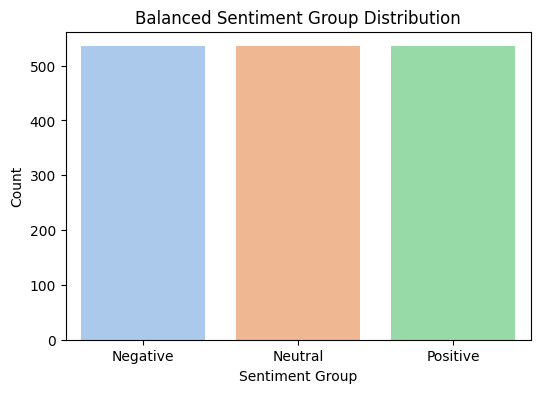

In [47]:
# ---------------------------------
# Sentiment Analysis & 5-Point Rating Generation (Revised Logic)
# ---------------------------------
# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()
flair_analyzer = flair.models.TextClassifier.load('en-sentiment')
roberta_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
longformer_classifier = pipeline("sentiment-analysis", model="allenai/longformer-base-4096")

# Customize VADER lexicon
new_words = {
    "falsely advertised": -3.0,
    "overheating": -3.0,
    "returned": -2.0,
    "refunds": -1.5,
    "fortunate": 0.5
}
vader_analyzer.lexicon.update(new_words)

def get_vader_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    score = vader_analyzer.polarity_scores(text)['compound']
    return "Negative" if score <= -0.05 else "Positive" if score >= 0.05 else "Neutral"

def get_textblob_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    score = TextBlob(text).sentiment.polarity
    return "Positive" if score > 0 else "Negative" if score < 0 else "Neutral"

def get_flair_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"
    sentence = flair.data.Sentence(text)
    flair_analyzer.predict(sentence)
    if not sentence.labels:
        return "Neutral"
    sentiment = sentence.labels[0].value
    return "Positive" if sentiment == 'POSITIVE' else "Negative" if sentiment == 'NEGATIVE' else "Neutral"

def get_roberta_sentiment(text, max_length=512, overlap=128):
    if not isinstance(text, str):
        return "Neutral"
    chunks = []
    i = 0
    while i < len(text):
        chunks.append(text[i:i+max_length])
        i += max_length - overlap
    sentiment_scores = {"Positive": 0, "Negative": 0, "Neutral": 0}
    for chunk in chunks:
        result = roberta_classifier(chunk)[0]
        if result['label'] == 'LABEL_2':
            sentiment_scores["Positive"] += 1
        elif result['label'] == 'LABEL_0':
            sentiment_scores["Negative"] += 1
        else:
            sentiment_scores["Neutral"] += 1
    return max(sentiment_scores, key=sentiment_scores.get)

def get_longformer_sentiment(text, max_length=4096, overlap=512):
    if not isinstance(text, str):
        return "Neutral"
    chunks = []
    i = 0
    while i < len(text):
        chunks.append(text[i:i+max_length])
        i += max_length - overlap
    sentiment_scores = {"Positive": 0, "Negative": 0, "Neutral": 0}
    for chunk in chunks:
        result = longformer_classifier(chunk)[0]
        label = result['label']
        if "pos" in label.lower():
            sentiment_scores["Positive"] += 1
        elif "neg" in label.lower():
            sentiment_scores["Negative"] += 1
        else:
            sentiment_scores["Neutral"] += 1
    return max(sentiment_scores, key=sentiment_scores.get)

def get_adjusted_sentiment(text):
    negative_keywords = ["falsely advertised", "overheating", "returned", "refund", "issue"]
    positive_keywords = ["fortunately", "buy a new one"]
    neg_count = sum(1 for word in negative_keywords if word in text.lower())
    pos_count = sum(1 for word in positive_keywords if word in text.lower())
    # Revised logic: Use majority vote of the six signals.
    if pos_count >= 4:
        return "Positive"
    elif neg_count >= 4:
        return "Negative"
    else:
        return "Neutral"

print("\nStarted sentiment analysis...")
df['Sentiment_VADER'] = df['processed_comment'].apply(get_vader_sentiment)
df['Sentiment_TextBlob'] = df['processed_comment'].apply(get_textblob_sentiment)
df['Sentiment_Flair'] = df['processed_comment'].apply(get_flair_sentiment)
df['Sentiment_RoBERTa'] = df['processed_comment'].apply(get_roberta_sentiment)
df['Sentiment_Longformer'] = df['processed_comment'].apply(get_longformer_sentiment)
df['Sentiment_Adjusted'] = df['processed_comment'].apply(get_adjusted_sentiment)

# Revised rating: use majority vote over the six sentiment signals.
def calculate_rating(row):
    signals = [
        row['Sentiment_VADER'],
        row['Sentiment_TextBlob'],
        row['Sentiment_Flair'],
        row['Sentiment_RoBERTa'],
        row['Sentiment_Longformer'],
        row['Sentiment_Adjusted']
    ]
    pos_count = signals.count("Positive")
    neg_count = signals.count("Negative")
    if pos_count > neg_count:
        return "Positive"
    elif neg_count > pos_count:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment_Rating'] = df.apply(calculate_rating, axis=1)
print("Sentiment analysis complete. Sample:")
print(df[['comment_text', 'processed_comment', 'Sentiment_Rating']].head())

# ---------------------------------
# Map to 3-Class Output and Balance the Dataset
# ---------------------------------
# Our target is the 3-class label from Sentiment_Rating.
df['sentiment_group'] = df['Sentiment_Rating']

print("\nOriginal distribution by sentiment_group:")
print(df['sentiment_group'].value_counts())

# Balance the dataset so that each group (Negative, Neutral, Positive) is equally represented.
group_counts = df['sentiment_group'].value_counts()
min_group_count = group_counts.min()
balanced_df = df.groupby('sentiment_group').apply(lambda x: x.sample(n=min_group_count, random_state=42)).reset_index(drop=True)
print(f"\nBalanced dataset created with {len(balanced_df)} samples ({min_group_count} per group)")
print("Balanced distribution:")
print(balanced_df['sentiment_group'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment_group', data=balanced_df, palette='pastel')
plt.title("Balanced Sentiment Group Distribution")
plt.xlabel("Sentiment Group")
plt.ylabel("Count")
plt.show()

In [48]:


print(balanced_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   post_id                1605 non-null   object
 1   post_title             1605 non-null   object
 2   comment_id             1605 non-null   object
 3   author                 1493 non-null   object
 4   comment_text           1605 non-null   object
 5   score                  1605 non-null   int64 
 6   created_utc            1605 non-null   object
 7   is_submitter           1605 non-null   bool  
 8   contains_noon_mention  1605 non-null   bool  
 9   type                   1605 non-null   object
 10  subreddit              1376 non-null   object
 11  Sentiment_VADER        1605 non-null   object
 12  Sentiment_TextBlob     1605 non-null   object
 13  Sentiment_Flair        1605 non-null   object
 14  Sentiment_RoBERTa      1605 non-null   object
 15  Sentiment_Longformer 

In [49]:

# ---------------------------------
# 1. Data Preprocessing Function (with stemming and lemmatization)
# ---------------------------------

# Function to convert text to lowercase
def to_lowercase(text):
    return text.lower()

def remove_html_tags(text):
    if "<" in text and ">" in text:  
        return BeautifulSoup(text, "html.parser").get_text()
    return text  

# Function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)  # Remove links

# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Function to remove special characters
def remove_special_chars(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Function to remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# Function to convert emojis to text
def convert_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # Convert to lowercase, remove HTML tags, URLs, punctuation, special characters, stop words and convert emojis.
    text = to_lowercase(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_punctuation(text)
    text = remove_special_chars(text)
    text = remove_stopwords(text)
    text = convert_emojis(text)
    
    # Tokenize, remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in set(stopwords.words('english'))]
    
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Additionally apply stemming
    # stemmer = PorterStemmer()
    # final_tokens = [stemmer.stem(token) for token in lemmatized_tokens]
    
    return " ".join(lemmatized_tokens)



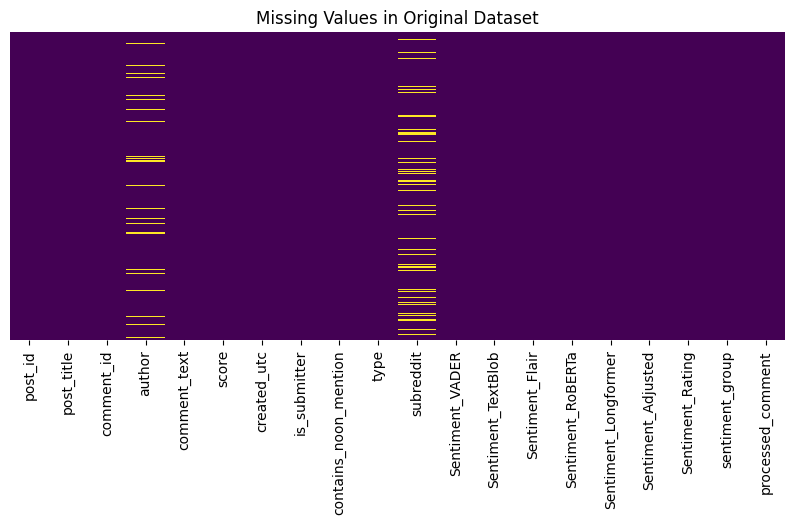

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   post_id                1605 non-null   object
 1   post_title             1605 non-null   object
 2   comment_id             1605 non-null   object
 3   author                 1493 non-null   object
 4   comment_text           1605 non-null   object
 5   score                  1605 non-null   int64 
 6   created_utc            1605 non-null   object
 7   is_submitter           1605 non-null   bool  
 8   contains_noon_mention  1605 non-null   bool  
 9   type                   1605 non-null   object
 10  subreddit              1376 non-null   object
 11  Sentiment_VADER        1605 non-null   object
 12  Sentiment_TextBlob     1605 non-null   object
 13  Sentiment_Flair        1605 non-null   object
 14  Sentiment_RoBERTa      1605 non-null   object
 15  Sentime

In [50]:
# ---------------------------------
# 2. Read Data, Preprocess, and Initial Data Visualization
# ---------------------------------
#file_path = "../Data/processed/Final_Noon_Datasets.csv"  # UPDATE PATH as needed
#df = pd.read_csv(file_path)
balanced_df['processed_comment'] = balanced_df['comment_text'].apply(preprocess_text)

# Visualize missing values and overall distribution
plt.figure(figsize=(10,4))
sns.heatmap(balanced_df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missing Values in Original Dataset")
plt.show()

print("Dataset Info:")
print(balanced_df.info())

# Display first few rows of preprocessed data
print(balanced_df[['comment_text', 'processed_comment']].head())

In [28]:
# ---------------------------------
# 3. Sentiment Analysis & 5-Point Rating Generation
# ---------------------------------
# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()
flair_analyzer = flair.models.TextClassifier.load('en-sentiment')
roberta_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
longformer_classifier = pipeline("sentiment-analysis", model="allenai/longformer-base-4096")

# Customize VADER lexicon
new_words = {
    "falsely advertised": -3.0,
    "overheating": -3.0,
    "returned": -2.0,
    "refunds": -1.5,
    "fortunate": 0.5
}
vader_analyzer.lexicon.update(new_words)

def get_vader_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    score = vader_analyzer.polarity_scores(text)['compound']
    return "Negative" if score <= -0.05 else "Positive" if score >= 0.05 else "Neutral"

def get_textblob_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    score = TextBlob(text).sentiment.polarity
    return "Positive" if score > 0 else "Negative" if score < 0 else "Neutral"

def get_flair_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"
    sentence = flair.data.Sentence(text)
    flair_analyzer.predict(sentence)
    if not sentence.labels:
        return "Neutral"
    sentiment = sentence.labels[0].value
    return "Positive" if sentiment == 'POSITIVE' else "Negative" if sentiment == 'NEGATIVE' else "Neutral"

def get_roberta_sentiment(text, max_length=512, overlap=128):
    if not isinstance(text, str):
        return "Neutral"
    chunks = []
    i = 0
    while i < len(text):
        chunks.append(text[i:i+max_length])
        i += max_length - overlap
    sentiment_scores = {"Positive": 0, "Negative": 0, "Neutral": 0}
    for chunk in chunks:
        result = roberta_classifier(chunk)[0]
        if result['label'] == 'LABEL_2':
            sentiment_scores["Positive"] += 1
        elif result['label'] == 'LABEL_0':
            sentiment_scores["Negative"] += 1
        else:
            sentiment_scores["Neutral"] += 1
    return max(sentiment_scores, key=sentiment_scores.get)

def get_longformer_sentiment(text, max_length=4096, overlap=512):
    if not isinstance(text, str):
        return "Neutral"
    chunks = []
    i = 0
    while i < len(text):
        chunks.append(text[i:i+max_length])
        i += max_length - overlap
    sentiment_scores = {"Positive": 0, "Negative": 0, "Neutral": 0}
    for chunk in chunks:
        result = longformer_classifier(chunk)[0]
        label = result['label']
        if "pos" in label.lower():
            sentiment_scores["Positive"] += 1
        elif "neg" in label.lower():
            sentiment_scores["Negative"] += 1
        else:
            sentiment_scores["Neutral"] += 1
    return max(sentiment_scores, key=sentiment_scores.get)

def get_adjusted_sentiment(text):
    negative_keywords = ["falsely advertised", "overheating", "returned", "refund", "issue"]
    positive_keywords = ["fortunately", "buy a new one"]
    neg_count = sum(1 for word in negative_keywords if word in text.lower())
    pos_count = sum(1 for word in positive_keywords if word in text.lower())
    if pos_count >= 4:
        return "Positive"
    elif neg_count >= 4:
        return "Negative"
    else:
        return "Neutral"

print("\nStarted sentiment analysis...")
df['Sentiment_VADER'] = df['processed_comment'].apply(get_vader_sentiment)
df['Sentiment_TextBlob'] = df['processed_comment'].apply(get_textblob_sentiment)
df['Sentiment_Flair'] = df['processed_comment'].apply(get_flair_sentiment)
df['Sentiment_RoBERTa'] = df['processed_comment'].apply(get_roberta_sentiment)
df['Sentiment_Longformer'] = df['processed_comment'].apply(get_longformer_sentiment)
df['Sentiment_Adjusted'] = df['processed_comment'].apply(get_adjusted_sentiment)

# New rating logic: if positive_count >= 4 then 'Positive'; if negative_count >= 4 then 'Negative'; else 'Neutral'
def calculate_rating(row):
    sentiments = [
        row['Sentiment_VADER'],
        row['Sentiment_TextBlob'],
        row['Sentiment_Flair'],
        row['Sentiment_RoBERTa'],
        row['Sentiment_Longformer'],
        row['Sentiment_Adjusted']
    ]
    positive_count = sentiments.count("Positive")
    negative_count = sentiments.count("Negative")
    if positive_count >= 3:
        return "Positive"
    elif negative_count >= 3:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment_Rating'] = df.apply(calculate_rating, axis=1)
print("Sentiment analysis complete. Sample:")
print(df[['comment_text', 'processed_comment', 'Sentiment_Rating']].head())




Started sentiment analysis...
Sentiment analysis complete. Sample:
                                        comment_text  \
0                          will reach border by noon   
1  Be careful of blowing dust during late morning...   
2  Apart from boring things, you can managed. How...   
3  You are looking at a tag in noon app saying 1 ...   
4  Are you sure? There's nothing indicating that ...   

                                   processed_comment Sentiment_Rating  
0                                 wll rech brer b nn          Neutral  
1  creful f blwng u urng le rnng r nn n n rue 1 f...          Neutral  
2  pr fr brng hng u cn nge hwever n lgh ple n r b...          Neutral  
3  u lkng g n nn pp ng 1 er wrrn n nn gve wrrn cl...          Neutral  
4  u ure nhng ncng h reng hrugh nn wrrn plc l nep...          Neutral  



Original distribution by sentiment_group:
sentiment_group
Neutral     3348
Positive     234
Negative      16
Name: count, dtype: int64

Balanced dataset created with 48 samples (16 per group)
Balanced distribution:
sentiment_group
Negative    16
Neutral     16
Positive    16
Name: count, dtype: int64


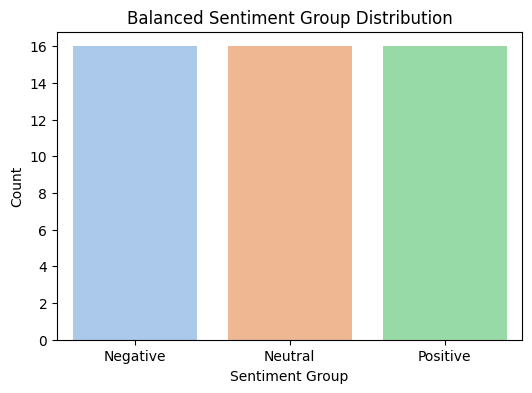

In [29]:
# ---------------------------------
# 4. Map to 3-Class Output and Balance the Dataset
# ---------------------------------
# Here our target is already the 3-class label (Positive, Negative, Neutral)
df['sentiment_group'] = df['Sentiment_Rating']

# Check the distribution before balancing
print("\nOriginal distribution by sentiment_group:")
print(df['sentiment_group'].value_counts())

# Balance each group equally.
group_counts = df['sentiment_group'].value_counts()
min_group_count = group_counts.min()
balanced_df = df.groupby('sentiment_group').apply(lambda x: x.sample(n=min_group_count, random_state=42)).reset_index(drop=True)
print(f"\nBalanced dataset created with {len(balanced_df)} samples ({min_group_count} per group)")
print("Balanced distribution:")
print(balanced_df['sentiment_group'].value_counts())

# Visualize distribution (bar plot and numbers)
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment_group', data=balanced_df, palette='pastel')
plt.title("Balanced Sentiment Group Distribution")
plt.xlabel("Sentiment Group")
plt.ylabel("Count")
plt.show()



In [51]:
# Optionally, save the preprocessed data

output_path = "../Data/processed/Final_Noon_Datasets_Preprocessed2702.xlsx"

balanced_df.to_excel(output_path, index=False)

print(f"Preprocessing complete. Results saved to {output_path}")

Preprocessing complete. Results saved to ../Data/processed/Final_Noon_Datasets_Preprocessed2702.xlsx


In [ ]:
file_path = "../Data/processed/Final_Noon_Datasets.csv"  # UPDATE PATH as needed
df = pd.read_excel(file_path)


Train-test split: 1284 training samples, 321 testing samples.


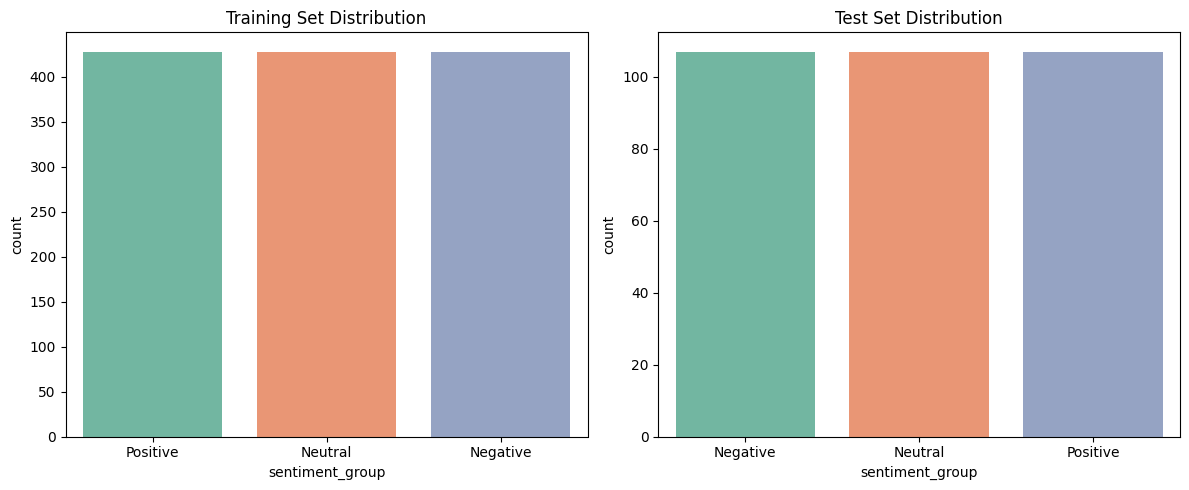

In [52]:
# ---------------------------------
# 5. Train-Test Split and Data Representation Visualizations
# ---------------------------------
X = balanced_df['processed_comment']
y = balanced_df['sentiment_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print(f"\nTrain-test split: {X_train.shape[0]} training samples, {X_test.shape[0]} testing samples.")

# Visualize split distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(x=y_train, palette='Set2')
plt.title("Training Set Distribution")
plt.subplot(1,2,2)
sns.countplot(x=y_test, palette='Set2')
plt.title("Test Set Distribution")
plt.tight_layout()
plt.show()




Vectorizing with Unigram model (ngram_range=(1, 1)) using TfidfVectorizer:
Accuracy with Unigram: 0.4860

Vectorizing with Bigram model (ngram_range=(1, 2)) using TfidfVectorizer:
Accuracy with Bigram: 0.4953

Vectorizing with Trigram model (ngram_range=(1, 3)) using TfidfVectorizer:
Accuracy with Trigram: 0.4984


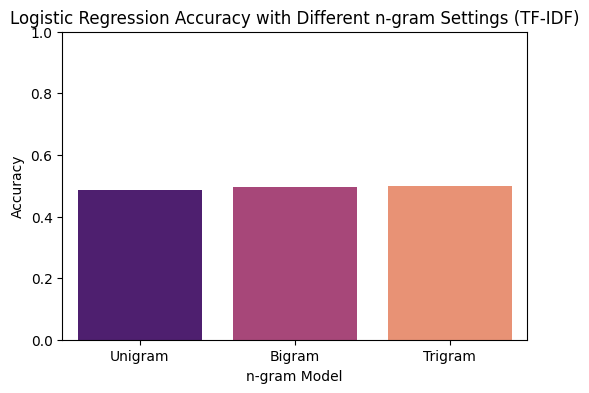


Logistic Regression Accuracy with CountVectorizer (binary counts): 0.4766


In [53]:
# ---------------------------------
# 6. Vectorization Experiments: CountVectorizer and TfidfVectorizer with different n-grams
# ---------------------------------
# Experiment with different n-gram ranges and options
ngram_settings = {
    "Unigram": (1,1),
    "Bigram": (1,2),
    "Trigram": (1,3)
}

vec_results = {}
for name, ngram_range in ngram_settings.items():
    print(f"\nVectorizing with {name} model (ngram_range={ngram_range}) using TfidfVectorizer:")
    tfidf_vec = TfidfVectorizer(max_features=5000, ngram_range=ngram_range, min_df=2, norm='l2')
    X_train_tfidf_ng = tfidf_vec.fit_transform(X_train)
    X_test_tfidf_ng = tfidf_vec.transform(X_test)
    
    # Train logistic regression on this representation
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train_tfidf_ng, y_train)
    y_pred = lr.predict(X_test_tfidf_ng)
    acc = accuracy_score(y_test, y_pred)
    vec_results[name] = acc
    print(f"Accuracy with {name}: {acc:.4f}")
    
# Compare results
plt.figure(figsize=(6,4))
sns.barplot(x=list(vec_results.keys()), y=list(vec_results.values()), palette="magma")
plt.title("Logistic Regression Accuracy with Different n-gram Settings (TF-IDF)")
plt.xlabel("n-gram Model")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

# Also create a CountVectorizer representation (binary occurrence)
count_vec = CountVectorizer(max_features=5000, ngram_range=(1,3), min_df=2)
X_train_count = count_vec.fit_transform(X_train)
X_test_count = count_vec.transform(X_test)
lr_count = LogisticRegression(random_state=42, max_iter=1000)
lr_count.fit(X_train_count, y_train)
y_pred_count = lr_count.predict(X_test_count)
acc_count = accuracy_score(y_test, y_pred_count)
print(f"\nLogistic Regression Accuracy with CountVectorizer (binary counts): {acc_count:.4f}")



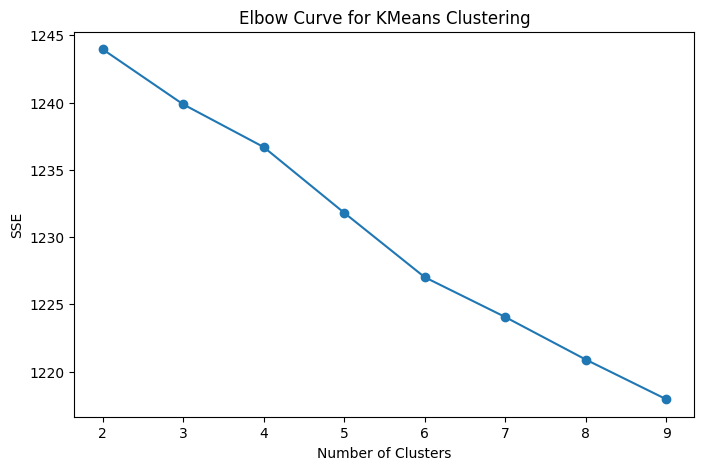

Silhouette Score for 3 clusters: 0.003


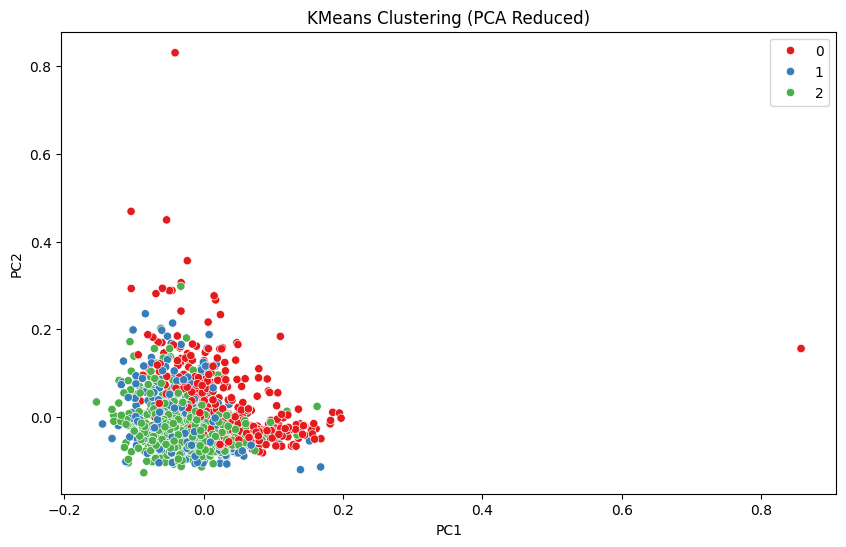

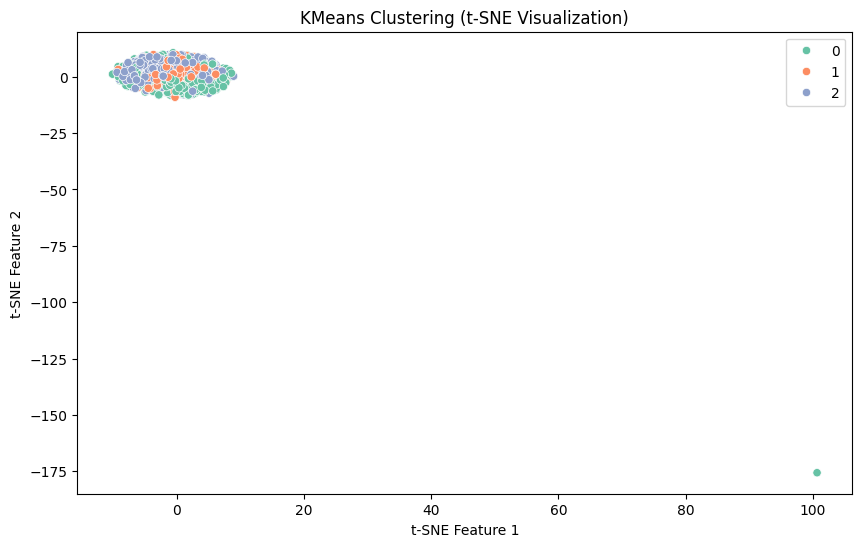

In [54]:
# ---------------------------------
# 7. Clustering Visualizations (using TF-IDF representation)
# ---------------------------------
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# Elbow curve for KMeans clustering
sse = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_train_tfidf)
    sse.append(km.inertia_)
plt.figure(figsize=(8,5))
plt.plot(range(2,10), sse, marker='o')
plt.title("Elbow Curve for KMeans Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# Perform clustering (e.g., 3 clusters) and visualize with PCA and t-SNE
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_tfidf)
sil_score = silhouette_score(X_train_tfidf, cluster_labels)
print(f"Silhouette Score for {num_clusters} clusters: {sil_score:.3f}")

# PCA Visualization
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=cluster_labels, palette="Set1")
plt.title("KMeans Clustering (PCA Reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=300)
X_train_tsne = tsne.fit_transform(X_train_tfidf.toarray())
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_train_tsne[:,0], y=X_train_tsne[:,1], hue=cluster_labels, palette="Set2")
plt.title("KMeans Clustering (t-SNE Visualization)")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.show()




LDA Topics:
(0, '0.016*"phne" + 0.014*"vern" + 0.013*"ke" + 0.013*"elver" + 0.012*"ure"')
(1, '0.016*"en" + 0.014*"cr" + 0.013*"cuer" + 0.012*"ke" + 0.011*"nw"')
(2, '0.019*"lke" + 0.018*"rer" + 0.017*"eller" + 0.015*"p" + 0.013*"ur"')
(3, '0.031*"eller" + 0.023*"wrrn" + 0.018*"reurn" + 0.014*"hn" + 0.014*"el"')
(4, '0.021*"p" + 0.018*"bugh" + 0.014*"ce" + 0.014*"never" + 0.013*"phne"')
LDA visualization saved to 'lda_vis.html'.


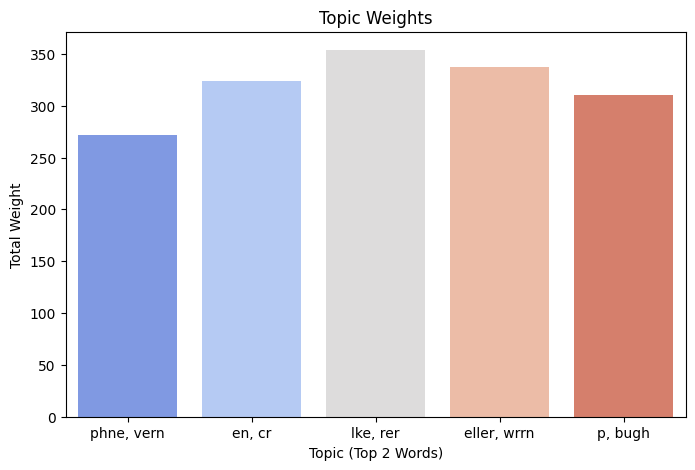

In [55]:
# ---------------------------------
# 8. Topic Modeling and Visualization using LDA and pyLDAvis
# ---------------------------------
# Prepare texts for topic modeling (tokenize each document)
texts = [doc.split() for doc in balanced_df['processed_comment'].tolist()]

# Create a gensim dictionary and filter extremes: remove words that appear in at least 15% of docs; limit to 10,000 words.
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_above=0.15, keep_n=10000)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, random_state=42, passes=10)
print("\nLDA Topics:")
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

# Visualize topics with pyLDAvis
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(lda_vis, 'lda_vis.html')
print("LDA visualization saved to 'lda_vis.html'.")

# Compute topic weights across the corpus and name topics by top 2 words
topic_weights = np.zeros(lda_model.num_topics)
for doc in corpus:
    doc_topics = lda_model.get_document_topics(doc)
    for topic_id, weight in doc_topics:
        topic_weights[topic_id] += weight
topic_names = []
for i in range(lda_model.num_topics):
    terms = lda_model.show_topic(i, topn=2)
    name = ", ".join([term for term, prob in terms])
    topic_names.append(name)
plt.figure(figsize=(8,5))
sns.barplot(x=topic_names, y=topic_weights, palette="coolwarm")
plt.title("Topic Weights")
plt.xlabel("Topic (Top 2 Words)")
plt.ylabel("Total Weight")
plt.show()



In [58]:
# ---------------------------------
# 9. Model Training with Parameter Grids and Best-Parameter Selection
# ---------------------------------
# Define parameter grids for some models
param_grids = {
    "Support Vector Machine": {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'max_iter': [1000, 2000]
    },
    "Neural Network": {
        'hidden_layer_sizes': [(100,), (200,)],
        'max_iter': [300, 500]
    }
}

# Create a dictionary of models.
models = {}
models["Naive Bayes"] = MultinomialNB()
models["K-Nearest Neighbors"] = KNeighborsClassifier()

# For grid-searched models, use GridSearchCV.
svm_grid = GridSearchCV(SVC(probability=True, random_state=42),
                        param_grids["Support Vector Machine"],
                        cv=5, n_jobs=-1)
models["Support Vector Machine"] = svm_grid

lr_grid = GridSearchCV(LogisticRegression(random_state=42),
                       param_grids["Logistic Regression"],
                       cv=5, n_jobs=-1)
models["Logistic Regression"] = lr_grid

nn_grid = GridSearchCV(MLPClassifier(random_state=42),
                       param_grids["Neural Network"],
                       cv=5, n_jobs=-1)
models["Neural Network"] = nn_grid

# Also add Random Forest
models["Random Forest"] = RandomForestClassifier(n_estimators=200, random_state=42)

results = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {"accuracy": acc,
                     "report": classification_report(y_test, y_pred, output_dict=True),
                     "confusion_matrix": confusion_matrix(y_test, y_pred)}
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    plt.figure(figsize=(6,4))
    sns.heatmap(results[name]["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Check for models with accuracy > 80%
qualified_models = {name: res for name, res in results.items() if res["accuracy"] >= 0.80}
if qualified_models:
    best_model_name = max(qualified_models, key=lambda x: qualified_models[x]["accuracy"])
    print(f"\nBest performing model with >80% accuracy: {best_model_name} (Accuracy: {results[best_model_name]['accuracy']:.4f})")
    best_estimator = models[best_model_name]
    if hasattr(best_estimator, "best_params_"):
        print("Best Parameters:", best_estimator.best_params_)
else:
    print("\nNo model achieved more than 80% accuracy. Consider further tuning or advanced feature engineering.")

# ---------------------------------
# End of Pipeline
# ---------------------------------


Training Naive Bayes ...


NameError: name 'X_test_tfidf' is not defined